In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import OrderedDict
from utils.dicts import df_map_features, df_map_pred, df_config

df = pd.read_csv("../data/imports-85.data", names=df_config["head"])

# Specify relevant data
df = df[[
    "brand",
    "fuel-type",
    "aspiration",
    "num-of-doors",
    "body-style",
    "drive-wheels",
    "engine-location",
    "wheel-base",
    "length",
    "width",
    "height",
    "curb-weight",
    "engine-type",
    "num-of-cylinders",
    "engine-size",
    "fuel-system",
    "bore",
    "stroke",
    "compression-ratio",
    "horsepower",
    "peak-rpm",
    "city-mpg",
    "highway-mpg",
    "price"
]]

# Drop rows with missing values in selected cols
df = df.replace("?", np.nan)

# Drop rows with missing values
df_nafree = df.dropna()

df_only_na = df[~df.index.isin(df_nafree.index)].reset_index(drop=True)
df_only_na = df_only_na.replace(np.nan, "0")
# print(df_only_na)

df.dropna(inplace=True)


In [2]:

# Feature <-> Prediction set
x = df[[
    "brand",
    "aspiration",
    "num-of-doors",
    "body-style",
    "drive-wheels",
    "engine-location",
    "wheel-base",
    "length",
    "width",
    "height",
    "curb-weight",
    "engine-type",
    "num-of-cylinders",
    "engine-size",
    "fuel-system",
    "bore",
    "stroke",
    "compression-ratio",
    "horsepower",
    "peak-rpm",
    "city-mpg",
    "highway-mpg",
    "price"
]]

# Feature <-> Prediction set for not complete data
xs = df_only_na[[
    "brand",
    "aspiration",
    "num-of-doors",
    "body-style",
    "drive-wheels",
    "engine-location",
    "wheel-base",
    "length",
    "width",
    "height",
    "curb-weight",
    "engine-type",
    "num-of-cylinders",
    "engine-size",
    "fuel-system",
    "bore",
    "stroke",
    "compression-ratio",
    "horsepower",
    "peak-rpm",
    "city-mpg",
    "highway-mpg",
    "price"
]]


def dict_mapping(dataset: dict):
  # Replacing feature attributes with numbers
    for feature in df_map_features:
        dataset = dataset.replace(df_map_features[feature][0])
    return dataset


x = dict_mapping(x)
xs = dict_mapping(xs)

y = df["fuel-type"]
y = y.replace(df_map_pred["fuel-type"][0])

ys = df_only_na["fuel-type"]
ys = ys.replace(df_map_pred["fuel-type"][0])

# Set the object type as float
x = x.astype(float)
x = x.values

xs = xs.astype(float)
xs = xs.values

y = y.astype(int)
y = y.values

ys = ys.astype(int)
ys = ys.values


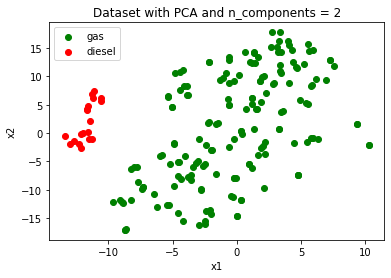

In [3]:
from utils.plotting import plot_dataset_pcatsne
from utils.pcatsne import standardized_tsne

# Experimenting with n_components to get a good variance ratio
n_components = 2
ramdom_state = 8

tsne, x_tsne = standardized_tsne(x, n_components, ramdom_state)
xtsne, xs_tsne = standardized_tsne(xs, n_components, ramdom_state)


plot_dataset_pcatsne(x_tsne, y, "Dataset with PCA and n_components = %i" %
                     n_components, ["diesel", "gas"])

In [4]:
# Split dataset in trianset and testset
from sklearn.model_selection import train_test_split

# Split train/test of main dataset (x)
x_train, x_test, y_train, y_test = train_test_split(
    x_tsne, y, test_size=0.35, random_state=15)


In [5]:
from utils.plotting import plot_knn_boundaries
from sklearn.neighbors import KNeighborsClassifier

_n_neighbors = 1

for weights in ['uniform', 'distance']:
  neigh = KNeighborsClassifier(n_neighbors=_n_neighbors, weights=weights)
  neigh.fit(x_train, y_train)

  # Get predicted result and storing it in a dataframe
  result = neigh.predict(xs_tsne)
  result = pd.DataFrame(
      {'predicted fuel-type': result, 'actual fuel-type': ys})
  # Replace the logical values with their corresponding fuel-types
  result = result.replace(df_map_pred["fuel-type-back"][0])

  print(f"Result for {weights}-classifier:\n{result}\n")


Result for uniform-classifier:
   predicted fuel-type actual fuel-type
0                  gas              gas
1                  gas              gas
2                  gas              gas
3                  gas              gas
4                  gas              gas
5                  gas              gas
6                  gas              gas
7                  gas              gas
8               diesel           diesel
9                  gas              gas
10                 gas              gas
11                 gas              gas

Result for distance-classifier:
   predicted fuel-type actual fuel-type
0                  gas              gas
1                  gas              gas
2                  gas              gas
3                  gas              gas
4                  gas              gas
5                  gas              gas
6                  gas              gas
7                  gas              gas
8               diesel           diesel
9               

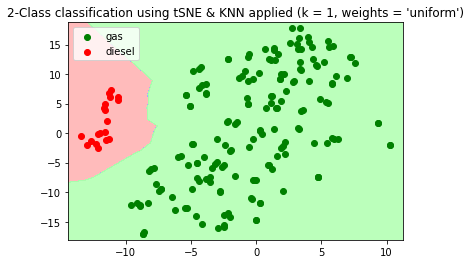

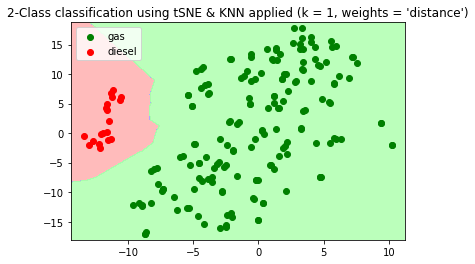

In [6]:
for weights in ['uniform', 'distance']:
  neigh = KNeighborsClassifier(n_neighbors=_n_neighbors, weights=weights)
  neigh.fit(x_train, y_train)

  plot_knn_boundaries(x_tsne, y, neigh, "2-Class classification using tSNE & KNN applied (k = %i, weights = '%s')"
                      % (_n_neighbors, weights), ["diesel", "gas"])


# Performing Clustering & KMeans if classes where hidden

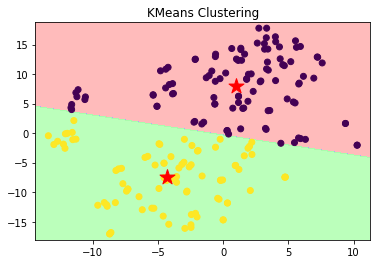

Score: -9150.072537957505


In [8]:
from utils.plotting import plot_kmeans_boundaries
from sklearn.cluster import KMeans

# Cast to double
x_tsne = x_tsne.astype('double')

kmeans = KMeans(n_clusters=2, max_iter=3_000)
kmeans.fit(x_tsne)
y_pred = kmeans.predict(x_tsne)

plot_kmeans_boundaries(
    x_tsne, x_tsne[1], y_pred, kmeans.cluster_centers_, kmeans, 'KMeans Clustering')

score = kmeans.score(x_tsne, y)
print(f"Score: {score}")


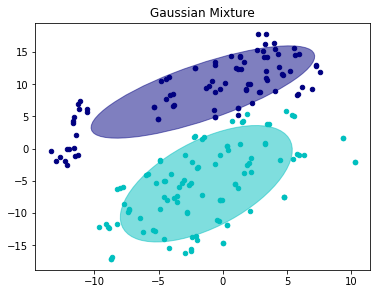

In [9]:
from utils.plotting import plot_gaussian_cluster
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=2,
    covariance_type='full').fit(x_tsne)

y_pred = gmm.predict(x_tsne)

plot_gaussian_cluster(x_tsne, y_pred, gmm.means_, gmm.covariances_, 0,
                      'Gaussian Mixture')
